In [22]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse 
import scipy.linalg as alg
import scipy.sparse.linalg as spl
import skimage.data

In [23]:
# 1 For colab
# from google.colab import drive
# drive.mount('/content/drive')
# data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Statistica/Homework/data.csv") 

In [24]:
# 1 without colab
data = pd.read_csv("data.csv")

In [25]:
print(data.head())
print(data.shape)

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [26]:
# Utils

def split(X, Y, Ntrain):
    d, N = X.shape

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]
    
    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]

    return Xtrain, Ytrain, Xtest, Ytest

def get_centroid(X):
    return np.mean(X, axis=1)

def get_clusters(Z, Y, choosen_numbers):
  clusters = list()
  for i in choosen_numbers:
    Ii = (Y==i)
    clusters.append(Z[:,Ii])
  return clusters

def concatenation(X_set, Y_set, chosen_indexes):
  I = []
  chosen_X = []
  chosen_Y = []

  d, N = X_set.shape
  for element in chosen_indexes:
    I.append((Y_set == element))
  
  for i in range(len(chosen_indexes)):
    chosen_X.append(X_set[:,I[i]])
    chosen_Y.append(Y_set[I[i]])
    
  X_conc = np.concatenate(chosen_X, axis=1)
  Y_conc = np.concatenate(chosen_Y)
  return chosen_X, chosen_Y, X_conc, Y_conc

def distances(Z, Y_conc, choosen_numbers, type):
  clusters = get_clusters(Z, Y_conc, choosen_numbers)

  centroids = []
  for cluster in clusters:
    centroids.append(get_centroid(cluster))
  
  print("Distances from centroids:")
  for j in range(len(choosen_numbers)):
    tot = 0
    for i in range(0,len(clusters[j])):
        tot = tot + np.linalg.norm(clusters[j][:,i] - centroids[j])
    dist = tot / len(clusters[j])
    print("Average distance between elements in cluster " + str(choosen_numbers[j]) + " from "+ type + " and centroid: ",str(dist))
    
def accuracy(X, Y, P, choosen_numbers, clusters, type):
  acc = 0
  centroids = []
  for cluster in clusters:
    centroids.append(get_centroid(cluster))
  print()
  print("Accuracy in classification:")
  for i in range(X.shape[1]):
    x = X[:, i]
    projected_x = P @ x
    min_dist = np.linalg.norm(projected_x - centroids[0])
    selected_cluster = choosen_numbers[0]
    for j,num in enumerate(choosen_numbers):
      if(np.linalg.norm(projected_x - centroids[j]) < min_dist):
        min_dist = np.linalg.norm(projected_x - centroids[j])
        selected_cluster = num
    if(selected_cluster == Y[i]):
      acc += 1
  print("Total test for accuracy: ", X.shape[1])
  print("Toatal right guess for algorithm ", type, "= ", acc)
  acc /= X.shape[1]
  print("Accuracy is: ", acc*100, "%")
  


def plot(Z, Y_conc, choosen_numbers, k, limit_axes=False):
  clusters = list()
  for i in choosen_numbers:
    Ii = (Y_conc==i)
    clusters.append(Z[:,Ii])
  centroids = list()
  for cluster in clusters:
    centroids.append(get_centroid(cluster))
  if(k == 2):
    plt.scatter(Z[0,:], Z[1,:], c=Y_conc)
    if (limit_axes):
      plt.xlim(-1,1)
      plt.ylim(-1,1)
    for element in centroids:
        plt.scatter(element[0], element[1], marker="x", color='r')
    plt.show()
  elif(k == 3):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(Z[0,:], Z[1,:], Z[2,:], c=Y_conc)
    if (limit_axes):
      ax.set_xlim(-1,1)
      ax.set_ylim(-1,1)
      ax.set_zlim(-1,1)
    for element in centroids:
        ax.scatter(element[0], element[1],element[2], color='r')
    plt.show()
  else:
    pass

In [27]:
# 2
data = np.array(data)
print(data.shape)
X = data[:, 1:].T
Y = data[:, 0]

print(X.shape)
print(Y.shape)

(42000, 785)
(784, 42000)
(42000,)


In [28]:
# PCA (def)

def PCA(X_set, Y_set, chosen_indexes, k):
    chosen_X, chosen_Y, X_conc, Y_conc = concatenation(X_set, Y_set, chosen_indexes)
    centroid = get_centroid(X_conc)
    centroid = np.reshape(centroid, (len(centroid), 1))
    Xc = X_conc - centroid
    U, S, Vh = np.linalg.svd(Xc, full_matrices=False)
    Uk = U[:,:k]
    return Uk.T@Xc, Uk.T, Y_conc

In [29]:
# LDA (def)

def LDA(X_set,Y_set, chosen_indexes, k):
    d, N = X_set.shape
    chosen_X, chosen_Y, X_conc, Y_conc = concatenation(X_set,Y_set, chosen_indexes)

    centroids = []
    Xcs = []
    CX = get_centroid(X_conc)

    for element in chosen_X:
        centroids.append(get_centroid(element).reshape((d,1)))
    
    for i in range(len(chosen_indexes)):
        Xcs.append(chosen_X[i] - centroids[i])

    Xw = np.concatenate(Xcs, axis=1)
    Sw = Xw @ Xw.T

    X_s = []
    for i in range(len(centroids)):
        X_s.append(np.repeat(centroids[i], chosen_X[i].shape[1], axis=1))
        
    X_ = np.concatenate(X_s, axis=1)
    X_c = X_ - CX.reshape((d, 1))
    Sb = X_c @ X_c.T

    L = []
    try: 
        L = np.linalg.cholesky(Sw)
    except:
        eps = 1e-6
        Sw = Sw + eps * np.eye(Sw.shape[0])
        L = np.linalg.cholesky(Sw)

    W = np.linalg.inv(L) @ Sb @ L
    _, W = spl.eigs(W,k=k)
    W = np.real(W)
    Q = np.linalg.inv(L).T @ W
    Z = Q.T @ X_conc
    return Z, Q.T, Y_conc

In [30]:
# Definition of train-data and test-data

Ntrain = 35000
Xtrain, Ytrain, Xtest, Ytest = split(X, Y, Ntrain)
print(Xtrain.shape, Xtest.shape)

(784, 35000) (784, 7000)


## Exercises for PCA

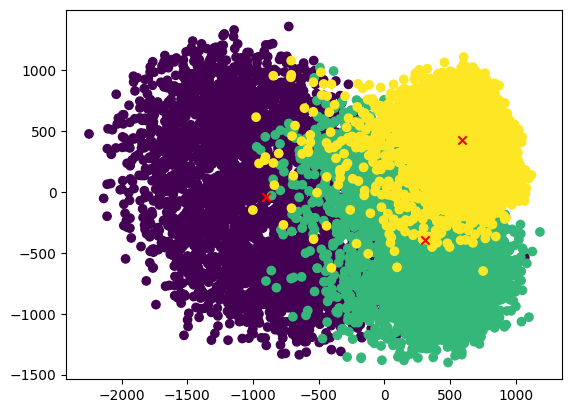

Distances from centroids:
Average distance between elements in cluster 0 from pca and centroid:  631.4033626712045
Average distance between elements in cluster 6 from pca and centroid:  523.897131192833
Average distance between elements in cluster 9 from pca and centroid:  364.48726004109153

Accuracy in classification:
Total test for accuracy:  10360
Toatal right guess for algorithm  pca =  6630
Accuracy is:  63.996138996138995 %


In [31]:
# PCA (example)

chosen_indexes = [0,6,9]
k = 2
Z_pca, projection_pca, Y_conc = PCA(Xtrain, Ytrain, chosen_indexes, k)
clusters = get_clusters(Z_pca, Y_conc, chosen_indexes)
plot(Z_pca, Y_conc, chosen_indexes, k)
distances(Z_pca, Y_conc, chosen_indexes, "pca")

chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtrain, Ytrain, chosen_indexes)
accuracy(X_conc, Y_conc, projection_pca, chosen_indexes, clusters, "pca")


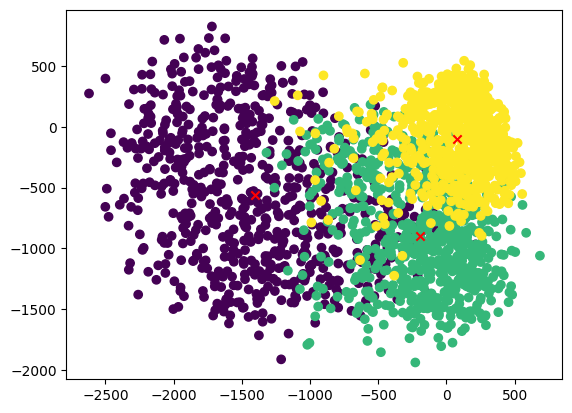

Distances from centroids:
Average distance between elements in cluster 0 from pca and centroid:  741.8308431527802
Average distance between elements in cluster 6 from pca and centroid:  858.4306045800073
Average distance between elements in cluster 9 from pca and centroid:  399.48532890562916

Accuracy in classification:
Total test for accuracy:  2097
Toatal right guess for algorithm  pca =  1775
Accuracy is:  84.64473056747734 %


In [32]:
# PCA (example on test set)

chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtest, Ytest, chosen_indexes)
Ztest_pca = projection_pca @ X_conc
clusters = get_clusters(Ztest_pca, Y_conc, chosen_indexes)
plot(Ztest_pca, Y_conc, chosen_indexes, k)
distances(Ztest_pca, Y_conc, chosen_indexes, "pca")
accuracy(X_conc, Y_conc, projection_pca, chosen_indexes, clusters, "pca")

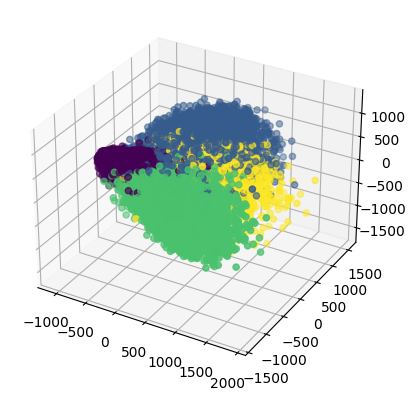

Distances from centroids:
Average distance between elements in cluster 1 from pca and centroid:  330.8142677022034
Average distance between elements in cluster 3 from pca and centroid:  627.3159661577365
Average distance between elements in cluster 6 from pca and centroid:  751.5714980420393
Average distance between elements in cluster 8 from pca and centroid:  657.8241680440104


Accuracy in classification:
Total test for accuracy:  14328
Toatal right guess for algorithm  pca =  7890
Accuracy is:  55.06700167504187 %


In [33]:
# PCA (example with k=3 and different/more digits)

chosen_indexes = [1,3,6,8]
k = 3
Z_pca, projection_pca, Y_conc = PCA(Xtrain, Ytrain, chosen_indexes, k)
plot(Z_pca, Y_conc, chosen_indexes, k)
clusters = get_clusters(Z_pca, Y_conc, chosen_indexes)
distances(Z_pca, Y_conc, chosen_indexes, "pca")
chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtrain, Ytrain, chosen_indexes)
print()
accuracy(X_conc, Y_conc, projection_pca, chosen_indexes, clusters, "pca")

## Exercises for LDA

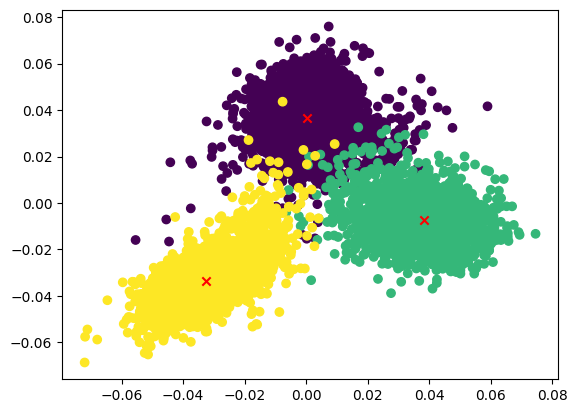

Distances from centroids:
Average distance between elements in cluster 0 from lda and centroid:  0.013309494790227722
Average distance between elements in cluster 6 from lda and centroid:  0.00927491671154093
Average distance between elements in cluster 9 from lda and centroid:  0.012457206504309006

Accuracy in classification:
Total test for accuracy:  10360
Toatal right guess for algorithm  lda =  10241
Accuracy is:  98.85135135135134 %


In [34]:
# LDA (example)

chosen_indexes = [0,6,9]
k = 2
Z_lda, projection_lda, Y_conc = LDA(Xtrain, Ytrain, chosen_indexes, k)
clusters = get_clusters(Z_lda, Y_conc, chosen_indexes)
plot(Z_lda, Y_conc, chosen_indexes, k)
distances(Z_lda, Y_conc, chosen_indexes, "lda")
chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtrain, Ytrain, chosen_indexes)
accuracy(X_conc, Y_conc, projection_lda, chosen_indexes, clusters, "lda")

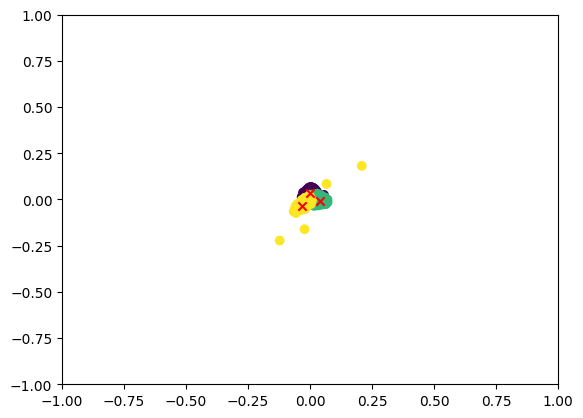

Distances from centroids:
Average distance between elements in cluster 0 from lda and centroid:  0.005333948310183315
Average distance between elements in cluster 6 from lda and centroid:  0.016085112160914225
Average distance between elements in cluster 9 from lda and centroid:  0.010690854688847411

Accuracy in classification:
Total test for accuracy:  2097
Toatal right guess for algorithm  lda =  2058
Accuracy is:  98.14020028612303 %


In [35]:
# LDA (example on test set)

chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtest, Ytest, chosen_indexes)
Ztest_lda = projection_lda @ X_conc
clusters = get_clusters(Ztest_lda, Y_conc, chosen_indexes)
plot(Ztest_lda, Y_conc, chosen_indexes, k,limit_axes=True)
distances(Ztest_lda, Y_conc, chosen_indexes, "lda")
accuracy(X_conc, Y_conc, projection_lda, chosen_indexes, clusters, "lda")

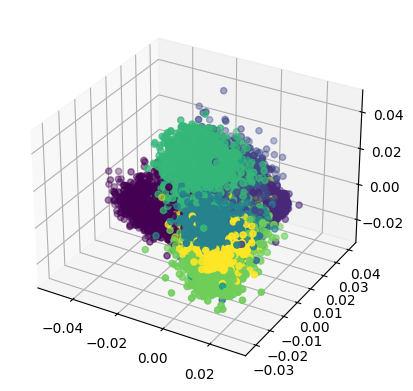

Distances from centroids:
Average distance between elements in cluster 0 from lda and centroid:  0.004438152012139841
Average distance between elements in cluster 1 from lda and centroid:  0.0034895959639708735
Average distance between elements in cluster 2 from lda and centroid:  0.008295095190324626
Average distance between elements in cluster 3 from lda and centroid:  0.008354339700977563
Average distance between elements in cluster 4 from lda and centroid:  0.009135649133628146
Average distance between elements in cluster 5 from lda and centroid:  0.01682522890368132
Average distance between elements in cluster 6 from lda and centroid:  0.010508080756175672
Average distance between elements in cluster 7 from lda and centroid:  0.015093144817705012
Average distance between elements in cluster 8 from lda and centroid:  0.006128855074318197
Average distance between elements in cluster 9 from lda and centroid:  0.0075786134807478275


Accuracy in classification:
Total test for accuracy

In [36]:
# LDA (example with k=3 and different/more digits)

chosen_indexes = [0,1,2,3,4,5,6,7,8,9]
k = 3
Z_lda, projection_lda, Y_conc = LDA(Xtrain, Ytrain, chosen_indexes, k)
plot(Z_lda, Y_conc, chosen_indexes, k)
clusters = get_clusters(Z_lda, Y_conc, chosen_indexes)
distances(Z_lda, Y_conc, chosen_indexes, "lda")
chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtrain, Ytrain, chosen_indexes)
print()
accuracy(X_conc, Y_conc, projection_lda, chosen_indexes, clusters, "lda")

# VISUALIZING DYAD

In [37]:
# 1
X = skimage.data.camera()
print("Image size: ",X.shape)

U, s, Vh = alg.svd(X)

Image size:  (512, 512)


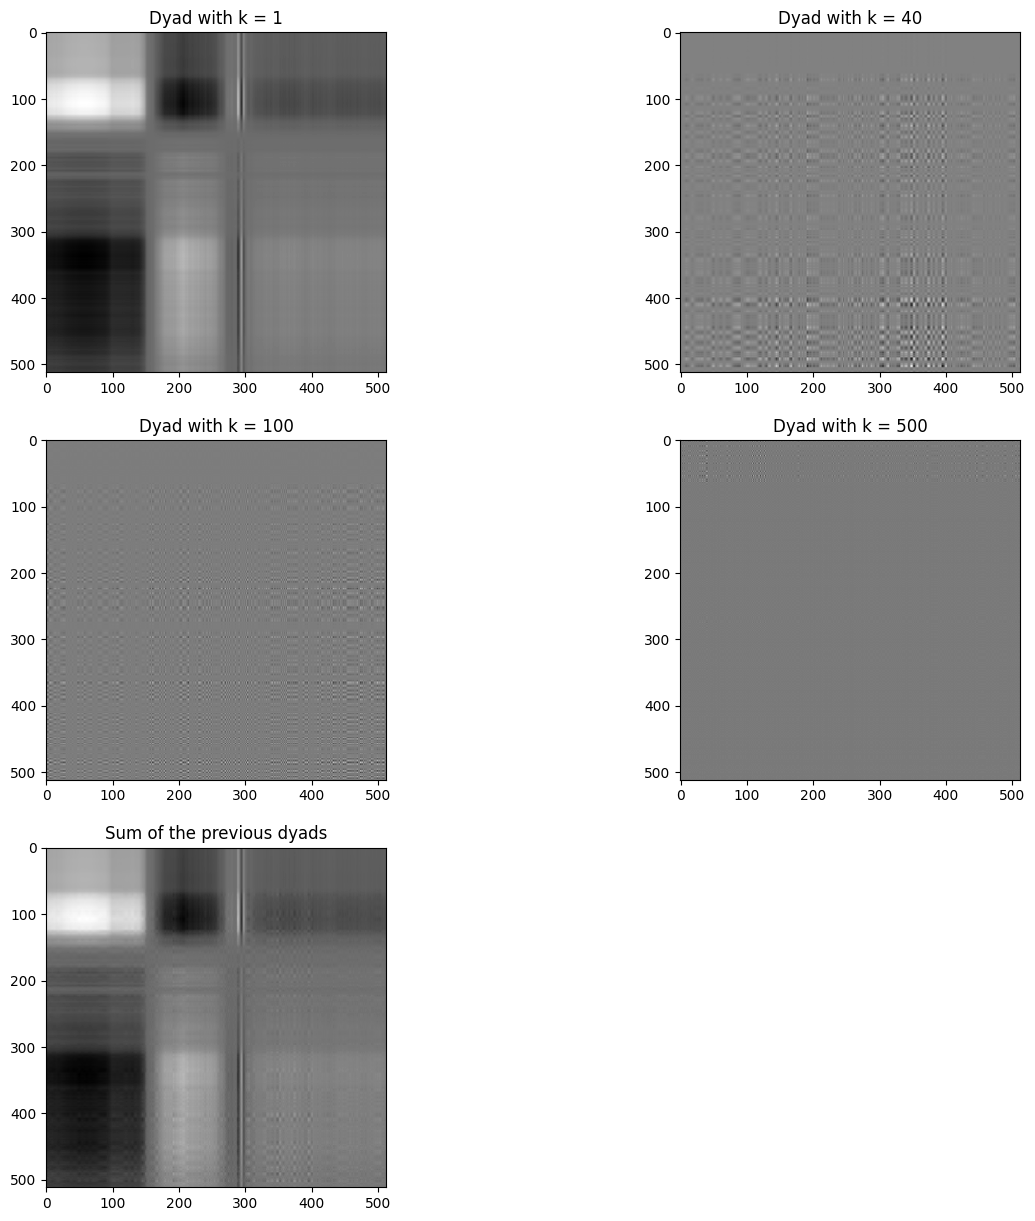

In [38]:
# 2
num = [1, 40, 100, 500]
dyads = []

for i in num:
  dyads.append(np.dot(U[:,i].reshape([U.shape[0],1]), Vh[i,:].reshape([1,Vh.shape[0]]))* s[i])

plt.figure(figsize=(15, 15))

fig1 = plt.subplot(3, 2, 1)
fig1.imshow(dyads[0], cmap='gray')
plt.title('Dyad with k = ' + str(num[0]))

fig2 = plt.subplot(3, 2, 2)
fig2.imshow(dyads[1], cmap='gray')
plt.title('Dyad with k = ' + str(num[1]))

fig3 = plt.subplot(3, 2, 3)
fig3.imshow(dyads[2], cmap='gray')
plt.title('Dyad with k = ' + str(num[2]))

fig4 = plt.subplot(3, 2, 4)
fig4.imshow(dyads[3], cmap='gray')
plt.title('Dyad with k = ' + str(num[3]))

summed_dyad = np.zeros(dyads[0].shape)
for dyad in dyads:
  summed_dyad = summed_dyad + dyad

fig5 = plt.subplot(3, 2, 5)
fig5.imshow(summed_dyad, cmap='gray')
plt.title('Sum of the previous dyads')
plt.show()





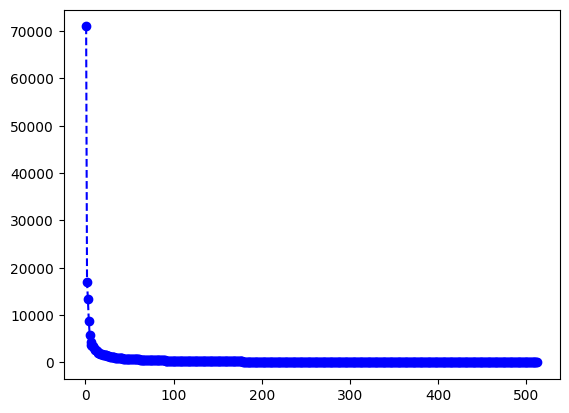

In [39]:
# 3
x_plot_s = np.linspace(1,len(s),len(s))
plt.plot(x_plot_s, s, '--bo')

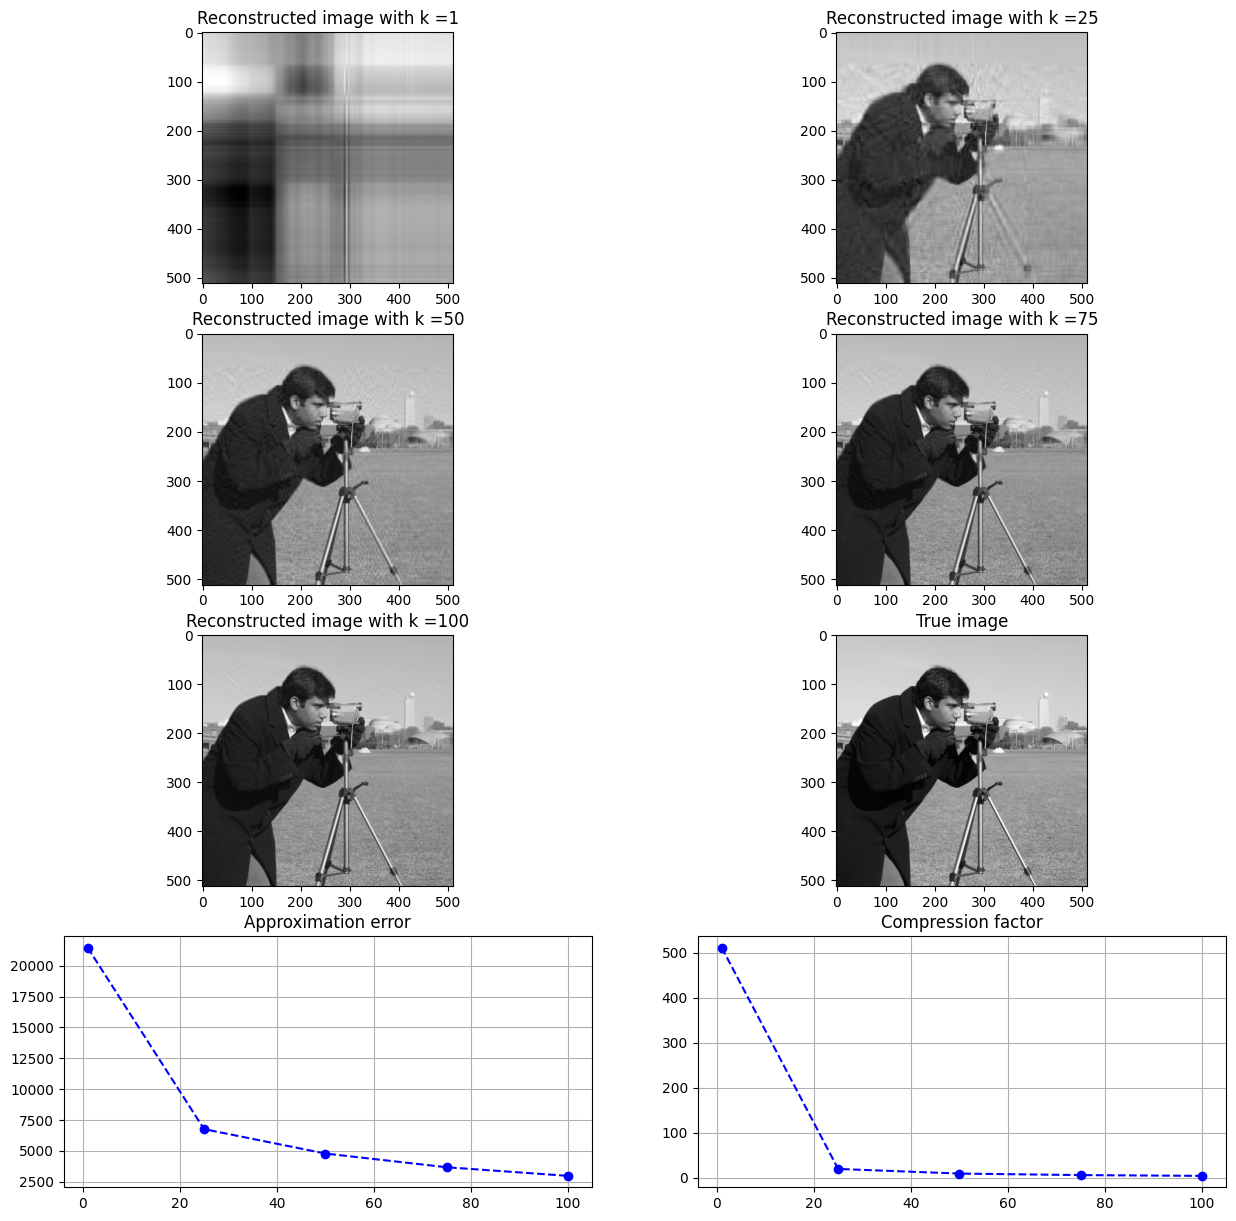

In [40]:
# 4,5,6

k = 100
toVisualize = [1, round(k/4), round(k/2), round(3 * k/4), k]
saved = []
errors = []
c_factors = []

X_k = np.zeros(X.shape)

for i in range(k+1):
  alph = np.dot(U[:,i].reshape([U.shape[0],1]), Vh[i,:].reshape([1,Vh.shape[0]]) )* s[i]
  X_k = X_k + alph
  if(i in toVisualize):
    errors.append(np.linalg.norm(X-X_k))
    c_factors.append(((1/i) * min(U.shape[0], Vh.shape[0])) -1)
    saved.append(X_k)

plt.figure(figsize=(15, 15))

fig1 = plt.subplot(4, 2, 1)
fig1.imshow(saved[0], cmap='gray')
plt.title('Reconstructed image with k =' + str(toVisualize[0]))

fig2 = plt.subplot(4, 2, 2)
fig2.imshow(saved[1], cmap='gray')
plt.title('Reconstructed image with k =' + str(toVisualize[1]))

fig3 = plt.subplot(4, 2, 3)
fig3.imshow(saved[2], cmap='gray')
plt.title('Reconstructed image with k =' + str(toVisualize[2]))

fig4 = plt.subplot(4, 2, 4)
fig4.imshow(saved[3], cmap='gray')
plt.title('Reconstructed image with k =' + str(toVisualize[3]))

fig5 = plt.subplot(4, 2, 5)
fig5.imshow(saved[4], cmap='gray')
plt.title('Reconstructed image with k =' + str(toVisualize[4]))

fig6 = plt.subplot(4, 2, 6)
fig6.imshow(X, cmap='gray')
plt.title("True image")

fig7 = plt.subplot(4, 2, 7)
fig7.plot(toVisualize, errors, '--bo')
plt.grid()
plt.title("Approximation error")

fig8 = plt.subplot(4, 2, 8)
fig8.plot(toVisualize, c_factors, '--bo')
plt.grid()
plt.title("Compression factor")

plt.show()